# Proximal Policy Optimization

In this tutorial we try to implement the proximal policy optimization using tensorflow.

## Importing Dependencies

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import gym, threading, queue

### Defining the hyperparameters

In [2]:
EP_MAX = 1000
EP_LEN = 500
N_WORKER = 4 # Number of parallel workers
GAMMA = 0.9 # reward discount factor
A_LR = 0.001 # actor learning rate
C_LR = 0.001 # critic learning rate
MIN_BATCH_SIZE = 64 # minimum batch size for updating PPO
UPDATE_STEP = 15 # loop update operation n-steps
EPSILON = 0.2 # for clipping surrogate objective
GAME = 'CartPole-v0'

### Creaiting the environment

In [3]:
env = gym.make(GAME)
S_DIM = env.observation_space.shape[0]
A_DIM = env.action_space.n

In [4]:
class PPONet(object) :
    def __init__(self) :
        self.sess = tf.Session()
        self.tfs = tf.placeholder(tf.float32,[None,S_DIM],'state')
        
        # critic
        w_init = tf.random_normal_initializer(0., .1)
        lc = tf.layers.dense(self.tfs,200,tf.nn.relu,kernel_initializer=w_init,name='lc')
        self.v = tf.layers.dense(lc,1)
        self.tfdc_r = tf.placeholder(tf.float32,[None,1],'dicounted_r')
        self.advantage = self.tfdc_r - self.v
        self.closs = tf.reduce_mean(tf.square(self.advantage))
        self.ctrain_op = tf.train.AdamOptimizer(C_LR).minimize(self.closs)
        
        # actor
        self.pi, pi_params = self._build_anet('pi',trainable=True)
        oldpi, oldpi_params = self._build_anet('oldpi',trainable=True)
        
        self.update_oldpi_op = [oldp.assign(p) for p, oldp in zip(pi_params,oldpi_params)]
        
        self.tfa = tf.placeholder(tf.int32,[None,],'action')
        self.tfadv = tf.placeholder(tf.float32,[None,1],'advantage')
        
        a_indices = tf.stack([tf.range(tf.shape(self.tfa)[0],dtype=tf.int32),self.tfa],axis=1)
        pi_prob = tf.gather_nd(params=self.pi,indices=a_indices) # shape = (None,)
        oldpi_prob = tf.gather_nd(params=oldpi,indices=a_indices) # shape = (None,)
        ratio = pi_prob/oldpi_prob
        surr = ratio * self.tfadv # surrogate loss
        
        self.aloss = -tf.reduce_mean(tf.minimum(surr,tf.clip_by_value(ratio,1. - EPSILON,1. + EPSILON)*self.tfadv))
        
        self.atrain_op = tf.train.AdamOptimizer(A_LR).minimize(self.aloss)
        self.sess.run(tf.global_variables_initializer())
        
    def update(self) :
        global GLOBAL_UPDATE_COUNTER
        while not COORD.should_stop() :
            if GLOBAL_EP < EP_MAX :
                UPDATE_EVENT.wait() # wait untill get batch data
                self.sess.run(self.update_oldpi_op) # copy pi to old pi
                data = [QUEUE.get() for _ in range(QUEUE.qsize())] # collect data from all workers
                data = np.vstack(data)
                s, a, r = data[:,:S_DIM], data[:,S_DIM:S_DIM + 1].ravel(), data[:,-1:]
                adv = self.sess.run(self.advantage,{self.tfs : s,self.tfdc_r:r})
                
                # update actor and critic in a update loop
                [self.sess.run(self.atrain_op,{self.tfs : s,self.tfa : a,self.tfadv : adv}) for _ in range(UPDATE_STEP)]
                [self.sess.run(self.ctrain_op,{self.tfs : s,self.tfdc_r : r}) for _ in range(UPDATE_STEP)]
                UPDATE_EVENT.clear() # updating finished
                GLOBAL_UPDATE_COUNTER = 0 # reset counter
                ROLLING_EVENT.set() # set roll-out available
    
    def _build_anet(self,name,trainable) :
        with tf.variable_scope(name) :
            l_a = tf.layers.dense(self.tfs,200,tf.nn.relu,trainable=trainable)
            a_prob = tf.layers.dense(l_a,A_DIM,tf.nn.softmax,trainable=trainable)
            
        params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope=name)
        return a_prob, params
    
    def choose_action(self,s) : # run by a local
        prob_weights = self.sess.run(self.pi,feed_dict={self.tfs: s[None, :]})
        action = np.random.choice(range(prob_weights.shape[1]),p=prob_weights.ravel()) # select action w.r.t. the action prob
        
        return action
    
    def get_v(self,s) :
        if s.ndim < 2 : s = s[np.newaxis, :]
        
        return self.sess.run(self.v,{self.tfs:s})[0,0]

In [5]:
class Worker(object) :
    def __init__(self,wid) :
        self.wid = wid
        self.env = gym.make(GAME).unwrapped
        self.ppo = GLOBAL_PPO
        
    def work(self) :
        global GLOBAL_EP, GLOBAL_RUNNING_R, GLOBAL_UPDATE_COUNTER
        
        while not COORD.should_stop() :
            s = self.env.reset()
            ep_r = 0
            buffer_s, buffer_a, buffer_r = [], [], []
            for t in range(EP_LEN) :
                if not ROLLING_EVENT.is_set() : # while global PPO is updating
                    ROLLING_EVENT.wait()         # wait untill PPO is updated
                    buffer_s, buffer_a, buffer_r = [], [], [] # clear history buffer, use new policy to collect data
                
                a = self.ppo.choose_action(s)
                s_,r, done,_ = self.env.step(a)
                if done :
                    r = -10
                buffer_s.append(s)
                buffer_a.append(a)
                buffer_r.append(r-1) # 0 for not done, -11 for down, Reward Engineering
                s  = s_
                ep_r += r
                
                GLOBAL_UPDATE_COUNTER += 1 # count to minimum batch size, no need to wait for other workers
                if t == EP_LEN - 1 or GLOBAL_UPDATE_COUNTER >= MIN_BATCH_SIZE or done :
                    if done :
                        v_s_  = 0# end of episode
                    else :
                        v_s_ = self.ppo.get_v(s_)
                        
                    discounted_r = []                      # compute discounted rewards
                    for r in buffer_r[::-1] :
                        v_s_ = r + GAMMA*v_s_
                        discounted_r.append(v_s_)
                        
                    discounted_r.reverse()
                    
                    bs, ba, br = np.vstack(buffer_s), np.vstack(buffer_a), np.array(discounted_r)[:,None]
                    
                    buffer_s, buffer_a, buffer_r = [], [], []
                    QUEUE.put(np.hstack((bs,ba,br))) # put data in the queue
                    if GLOBAL_UPDATE_COUNTER >= MIN_BATCH_SIZE :
                        ROLLING_EVENT.clear()   # stop collecting data
                        UPDATE_EVENT.set()      # globalPPO update
                        
                    if GLOBAL_EP >= EP_MAX :    # stop training
                        COORD.request_stop()
                        break
                        
                    if done :
                        break
                        
                # record reward changes, plot later
                if len(GLOBAL_RUNNING_R) == 0 :
                    GLOBAL_RUNNING_R.append(ep_r)
                else :
                    GLOBAL_RUNNING_R.append(GLOBAL_RUNNING_R[-1]*0.9 + ep_r*0.1)
                GLOBAL_EP += 1
                print('{0:.1f}%'.format(GLOBAL_EP/EP_MAX*100),'|W%i'%self.wid,'|Ep_r:%.2f'%ep_r,) 
                        

## Writing the Driver Function

In [6]:
tf.reset_default_graph()

0.1% |W0 |Ep_r:1.00
0.2% |W1 |Ep_r:1.00
0.3% |W2 |Ep_r:1.00
0.4%0.5% |W2 |Ep_r:2.00
 |W0 |Ep_r:2.00
0.6%0.7% |W1 |Ep_r:2.00
0.8% 0.9%1.0% |W1 |Ep_r:3.00
|W0 |Ep_r:3.00
 |W3 |Ep_r:1.00
1.1%  |W3 |Ep_r:2.00
1.2% |W0 |Ep_r:4.00
|W2 |Ep_r:3.00
1.3%1.4% |W0 |W3 |Ep_r:3.00
1.5%1.6% |Ep_r:5.00
 |W2 |Ep_r:4.00
1.7%1.8% |W2 |Ep_r:5.00
 |W0 |Ep_r:6.00
1.9%  |W3 |Ep_r:4.00
|W1 |Ep_r:4.002.0%2.1%  |W2 |Ep_r:6.00
2.2%
|W3 |Ep_r:5.00
2.3% |W0 |W2 |Ep_r:7.00
2.4% |W3 |Ep_r:6.00
 2.5% |W1 |Ep_r:5.00
|Ep_r:7.00
2.6%2.7% |W32.8% |W2 |Ep_r:8.00
  |Ep_r:7.00
2.9% |W3 |Ep_r:8.00
3.0%3.1%3.2% |W2 |Ep_r:9.00
|W0 |W1 |Ep_r:6.00
 |W3 |Ep_r:9.00
3.3%3.4%3.5% |W2 |Ep_r:10.00
 |W1 |Ep_r:7.00
 |W3 |Ep_r:10.00
 |Ep_r:8.00
3.6% |W0 |Ep_r:9.00
3.7%3.8%3.9% |W3 |Ep_r:11.00
 |W1 |Ep_r:8.00
4.0%4.1% 4.2% |W3 |Ep_r:12.00
|W2 |Ep_r:11.00
 |W0 |Ep_r:10.00 |W1 |Ep_r:9.00

4.3%4.4% |W3 |Ep_r:13.00
 |W14.5% |Ep_r:10.00
4.6% |W3 |Ep_r:14.00 |W0
 |Ep_r:11.00
4.7% |W3 |Ep_r:15.00
4.8%4.9%5.0% |W1 |Ep_r:11.00
 |W2 |Ep_r:12.00
 |W

45.8% |W2 |Ep_r:5.00
 45.9% |W1 |Ep_r:4.00
|W3 |Ep_r:6.00
46.0%46.1% |W0 |Ep_r:6.00
 |W246.2%  |W3 |Ep_r:7.00
|Ep_r:6.00
46.3% |W1 46.4%46.5%|Ep_r:5.00
 |W0 |Ep_r:7.00
 |W2 |Ep_r:7.00
46.6%46.7%46.8% |W2 |Ep_r:8.00
 |W0 |Ep_r:8.00
46.9%47.0% |W2 |Ep_r:9.00
 |W1 |Ep_r:6.00
47.1% |W3 |Ep_r:8.00
 |W0 |Ep_r:9.00
47.2% |W1 |Ep_r:7.00
47.3% |W0 |Ep_r:10.00
47.4%47.5% |W1 |Ep_r:8.00
47.6%  |W0 |Ep_r:11.00
|W3 |Ep_r:9.00
47.7%47.8% |W3 |Ep_r:10.00
 |W1 |Ep_r:9.00
47.9% |W0 |Ep_r:12.00
48.0% |W3 |Ep_r:11.00
48.1%48.2% |W0 |Ep_r:13.00
 |W2 |Ep_r:1.00
48.3% |W1 |Ep_r:10.00
48.4%48.5% |W3 |Ep_r:1.00
48.6%48.7% |W0 |Ep_r:14.00
 |W2 |Ep_r:2.00
 48.8%48.9% |W0 |Ep_r:15.00
|W1 |W3 |Ep_r:2.00
 |Ep_r:11.00
49.0%49.1% |W3 |Ep_r:3.00
49.2% |W0 |Ep_r:16.00
49.3%  |W3 |Ep_r:4.00
|W2 |Ep_r:3.00
49.4% |W2 |Ep_r:4.00
49.5%49.6% |W2 |Ep_r:5.00
49.7% |W3 |Ep_r:5.00
 |W0 |Ep_r:17.00
49.8%49.9% |W1 |Ep_r:1.00
 |W2 |Ep_r:6.00
50.0% |W1 |Ep_r:2.00
50.1% |W2 |Ep_r:7.00
50.2%50.3% |W0 |Ep_r:1.00
 50.4% |W1 |Ep_r:3.00


95.1%95.2%95.3% |W2 |Ep_r:13.00
 |W3 |Ep_r:15.00
95.4% |W1 |Ep_r:21.00
95.5% |W2 |Ep_r:14.00
95.6% |W0 |Ep_r:33.00
95.7% |W3 |Ep_r:16.00
95.8% |W2 |Ep_r:15.00
 |W1 |Ep_r:22.00
95.9% |W3 |Ep_r:17.00
96.0%96.1%96.2% |W1 |Ep_r:23.00
 |W3 |Ep_r:18.00
96.3% |W2 |Ep_r:16.00
 |W0 |Ep_r:34.00
96.4% |W2 |Ep_r:17.00
96.5%96.6% |W1 |Ep_r:24.00
 |W0 |Ep_r:35.00
96.7% |W1 |Ep_r:25.00
96.8% |W3 |Ep_r:1.00
96.9%97.0%97.1% |W1  |W3 |Ep_r:2.0097.2%|Ep_r:26.00
 |W2 |Ep_r:18.00
 
97.3% |W1 |Ep_r:27.00
|W0 |Ep_r:36.00
97.4%97.5% |W1 |W3  |Ep_r:28.00
|Ep_r:3.00
97.6%97.7% |W1  |W0 |Ep_r:37.00
|Ep_r:29.00
97.8% |W2 |Ep_r:1.00
97.9%98.0%98.1% |W0 |Ep_r:38.00
98.2% |W1 |Ep_r:30.00
 |W3 |Ep_r:4.00
 |W2 |Ep_r:2.00
98.3%98.4% 98.5%98.6% |W0 |Ep_r:39.00
|W3 |Ep_r:5.00
 |W2 |Ep_r:3.00
 |W1 |Ep_r:31.00
98.7%98.8% |W2 |Ep_r:4.00
98.9% |W1 |Ep_r:32.00
 |W0 |Ep_r:40.00
99.0%99.1% |W3 |Ep_r:6.00
99.2%99.3%  |W0 |Ep_r:41.00
 |W1 |Ep_r:33.00
|W2 99.4%|Ep_r:5.00
99.5%99.6%  |W0 |Ep_r:42.00
99.7% |W1 |Ep_r:1.00
 |W2|W3  |E

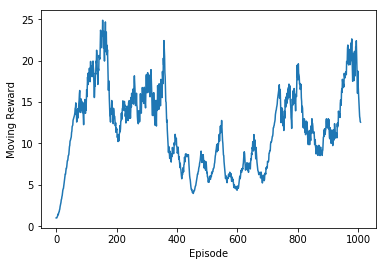

KeyboardInterrupt: 

In [7]:
GLOBAL_PPO = PPONet()
UPDATE_EVENT, ROLLING_EVENT = threading.Event(), threading.Event()
UPDATE_EVENT.clear()   # not update now
ROLLING_EVENT.set()    # start to roll out
workers = [Worker(wid=i) for i in range(N_WORKER)]

GLOBAL_UPDATE_COUNTER, GLOBAL_EP = 0,0
GLOBAL_RUNNING_R = []
COORD = tf.train.Coordinator()
QUEUE = queue.Queue()                  # workers putting data in this queue
threads = []
for worker in workers :              # worker threads
    t = threading.Thread(target=worker.work,args=())
    t.start()
    threads.append(t)
# add a PPO updating thread
threads.append(threading.Thread(target=GLOBAL_PPO.update,))
threads[-1].start()
COORD.join(threads)

# plot reward change and test
%matplotlib inline
plt.plot(np.arange(len(GLOBAL_RUNNING_R)),GLOBAL_RUNNING_R)
plt.xlabel('Episode')
plt.ylabel('Moving Reward')
plt.ion()
plt.show()
env = gym.make('CartPole-v0')
while True :
    s = env.reset()
    for t in range(1000) :
        env.render()
        s, r, done, info = env.step(GLOBAL_PPO.choose_action(s))
        if done :
            break